# Percentile Forecast Optimization

This notebook focuses on percentile-based forecasts.
It optimizes percentile targets first without aggregation, then with an aggregation window.


## Setup


In [1]:
import pandas as pd
import random
from dataclasses import replace

from replenishment import (
    PercentileForecastOptimizationPolicy,
    RopPercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_forecast_target_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)

### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [2]:
review_period = 3
forecast_horizon = 3
rmse_window = review_period  # optional; defaults to review_period


## Generate Sample Data


In [3]:
history_mean = 18
history_std = 10
forecast_mean = 17
forecast_std = 2
replenishment_start_period = 90

rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    forecast_start_period=replenishment_start_period,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    initial_on_hand=15,
    current_stock=15,
    lead_time=3,
   # seed=7,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=100,
    order_cost_per_order=10,
    percentile_multipliers={
        "p10": 0.6,
        "p15": 0.65,
        "p20": 0.70,
        "p25": 0.75,
        "p30": 0.80,
        "p35": 0.85,
        "p40": 0.90,
        "p45": 0.95,
        "p50": 1.0,
        "p55": 1.05,
        "p60": 1.10,
        "p65": 1.15,
        "p70": 1.20,
        "p75": 1.25,
        "p80": 1.30,
        "p85": 1.35,
        "p90": 1.40,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")


## Split Backtest vs Forecast


In [4]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)


# Add simulated actuals for the forecast/replenishment period so we can measure lost sales.
rng = random.Random(7)

def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

forecast_rows_actuals = [
    replace(row, actuals=_sample_int(history_mean, history_std), demand=_sample_int(history_mean, history_std))
    for row in forecast_rows
]
forecast_rows = forecast_rows_actuals

# Rebuild df so plots include actuals in replenishment period.
df = standard_simulation_rows_to_dataframe(
    backtest_rows + forecast_rows, library="pandas"
)

## Step 1: Optimize Percentile Target (No Aggregation)


In [5]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)
percentile_cost_df


,unique_id,target,total_cost
0,A,p10,82138.0
1,A,p15,78685.0
2,A,p20,75350.0
3,A,p25,71521.0
4,A,p30,68470.0
5,A,p35,64835.0
6,A,p40,61514.0
7,A,p45,59096.0
8,A,p50,55292.0
9,A,p55,51693.0


In [16]:
percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=3,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)
percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,68,23,23.333333,22.666667,70.0,140.0,0,15,...,0,68,0,8,None,3,3,3,3,p90
1,A,2031-06-23,0,15,22.333333,22.333333,67.0,134.0,0,0,...,0,68,0,15,None,3,3,3,3,p90
2,A,2031-07-23,0,16,21.666667,23.000000,65.0,130.0,0,0,...,0,68,0,16,None,3,3,3,3,p90
3,A,2031-08-22,23,22,22.666667,23.000000,68.0,136.0,68,68,...,46,23,0,0,None,3,3,3,3,p90
4,A,2031-09-21,0,20,22.333333,24.333333,67.0,134.0,0,46,...,26,23,0,0,None,3,3,3,3,p90


### Plot (No Aggregation)


<Axes: title={'center': 'Percentile decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

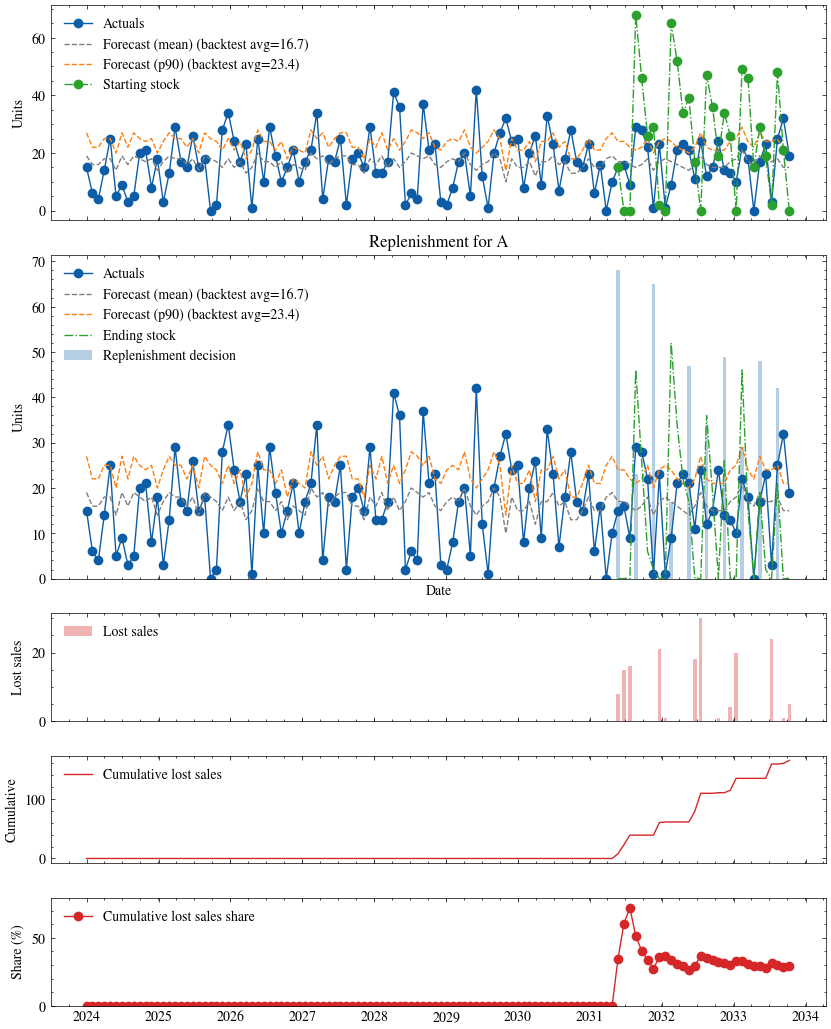

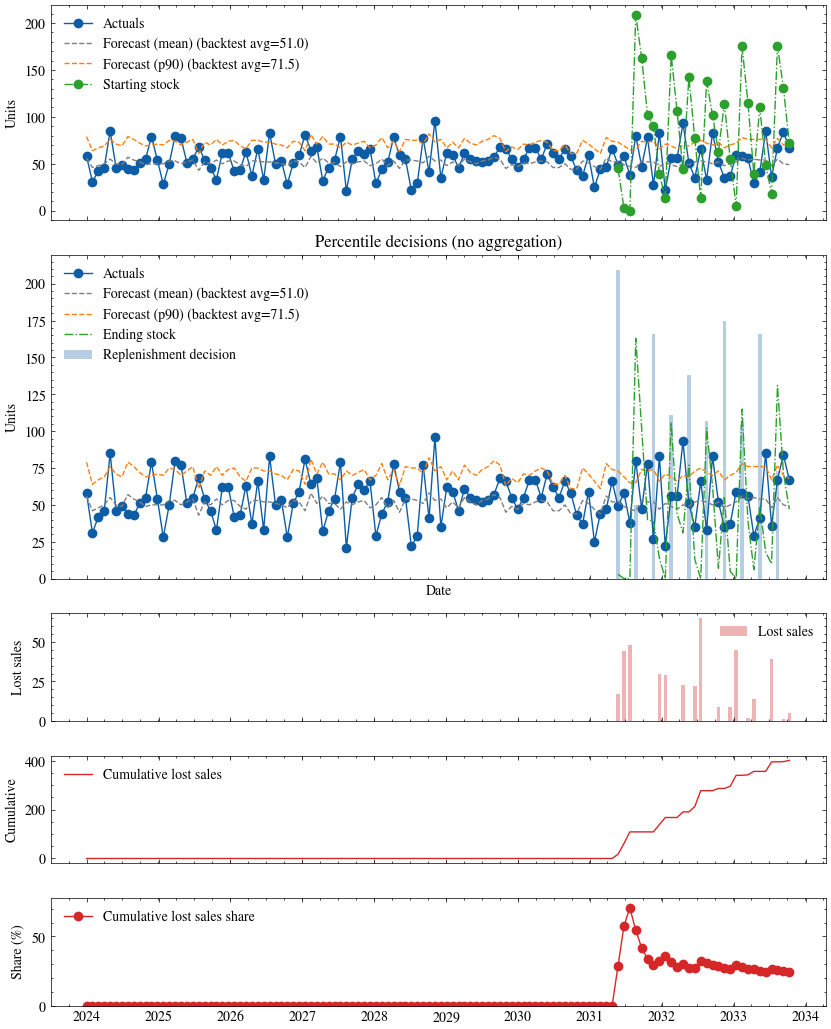

In [17]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Percentile Target


In [8]:
agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
)

agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_percentile_results.items()
}

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=agg_windows,
    forecast_horizon=agg_windows,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)
agg_percentile_decision_df.head(10)


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,183,23,22.750,22.875,70.0,252.0,0,15,...,0,183,0,8,None,8,8,8,8,p90
1,A,2031-06-23,0,15,22.875,22.875,67.0,250.0,0,0,...,0,183,0,15,None,8,8,8,8,p90
2,A,2031-07-23,0,16,22.875,22.625,65.0,248.0,0,0,...,0,183,0,16,None,8,8,8,8,p90
3,A,2031-08-22,0,22,22.875,22.250,68.0,251.0,183,183,...,161,0,0,0,None,8,8,8,8,p90
4,A,2031-09-21,0,20,22.875,23.125,67.0,250.0,0,161,...,141,0,0,0,None,8,8,8,8,p90
5,A,2031-10-21,0,20,22.625,22.875,69.0,250.0,0,141,...,121,0,0,0,None,8,8,8,8,p90
6,A,2031-11-20,0,27,22.250,22.375,69.0,247.0,0,121,...,94,0,0,0,None,8,8,8,8,p90
7,A,2031-12-20,0,23,23.125,22.000,73.0,258.0,0,94,...,71,0,0,0,None,8,8,8,8,p90
8,A,2032-01-19,105,1,22.875,21.875,71.0,254.0,0,71,...,70,105,0,0,None,8,8,8,8,p90
9,A,2032-02-18,0,13,22.375,22.250,67.0,246.0,0,70,...,57,105,0,0,None,8,8,8,8,p90


### Plot (Optimized Aggregation)


<Axes: title={'center': 'Percentile decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

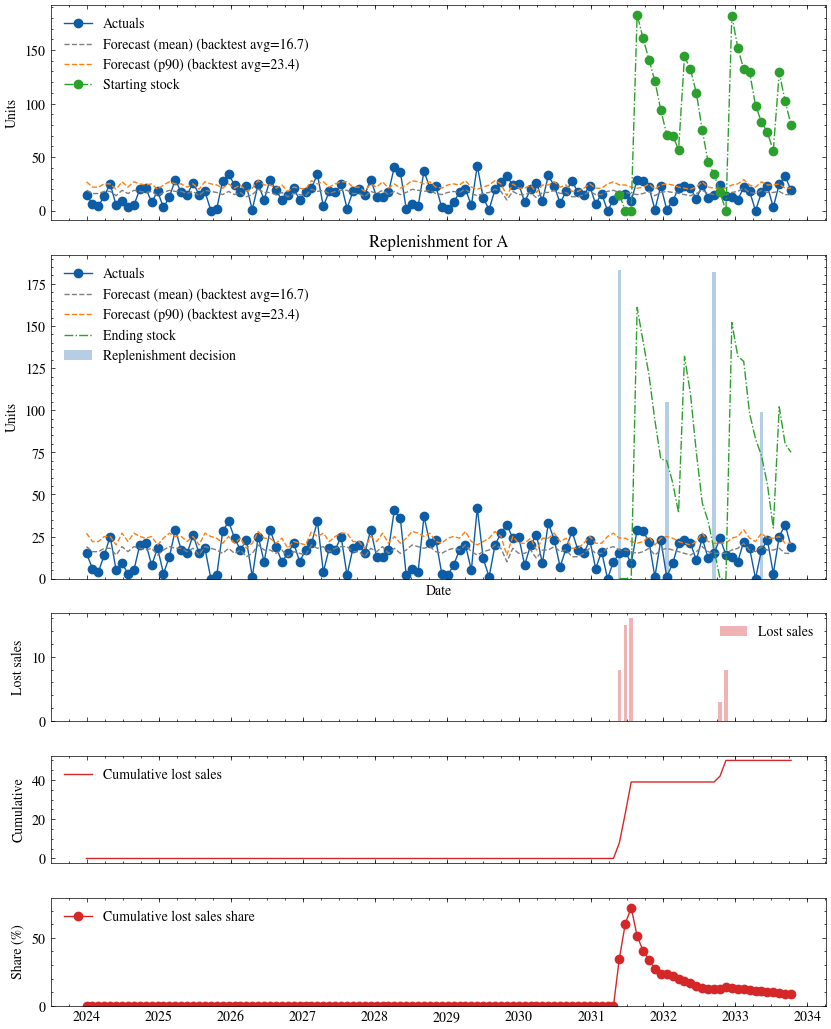

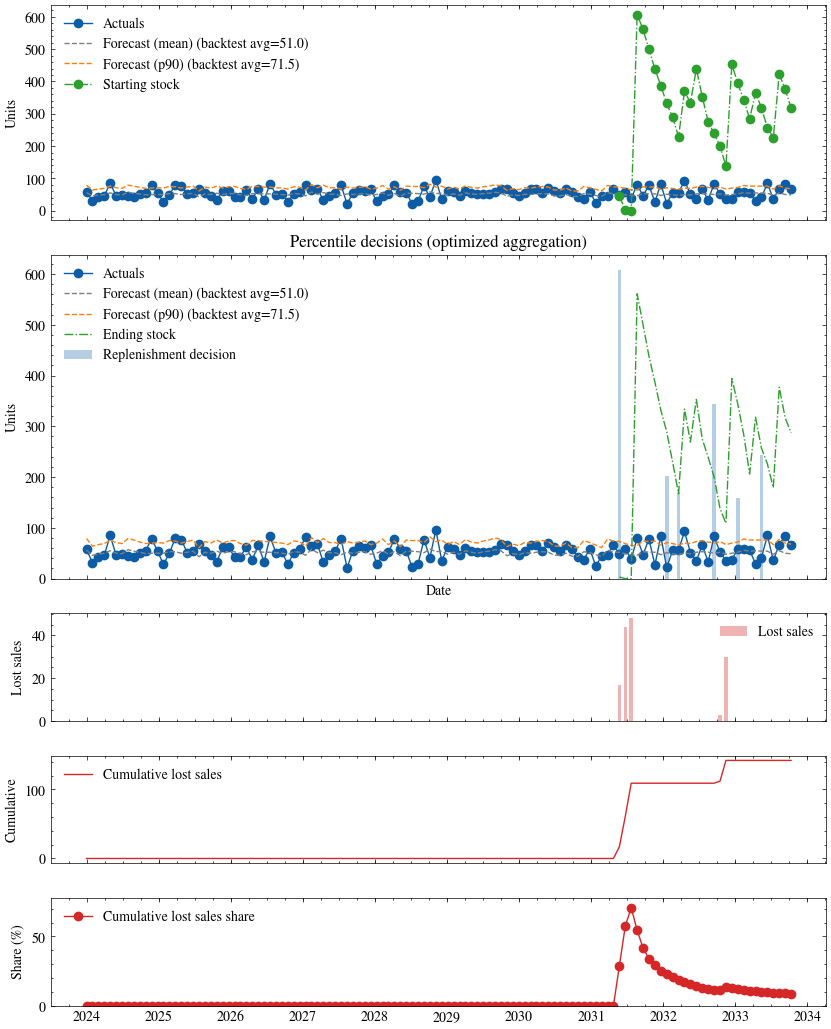

In [9]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)


## ROP policy (percentile targets)
This section optimizes percentile targets using a reorder-point trigger.


In [10]:
rop_percentile_results = optimize_forecast_targets(
    percentile_configs,
    policy_mode="rop",
)
rop_percentile_results


{'A': PercentileForecastOptimizationResult(target='p90', policy=RopPercentileForecastOptimizationPolicy(forecast=[27, 22, 22, 25, 25, 20, 27, 22, 27, 25, 24, 25, 20, 24, 27, 25, 25, 22, 25, 20, 27, 25, 24, 21, 25, 21, 24, 18, 21, 28, 24, 24, 21, 24, 18, 22, 21, 20, 28, 25, 27, 22, 25, 27, 27, 22, 22, 18, 25, 22, 27, 21, 25, 21, 24, 28, 27, 25, 27, 22, 21, 24, 25, 24, 28, 22, 20, 22, 24, 28, 25, 14, 25, 21, 21, 24, 17, 24, 24, 27, 22, 24, 18, 18, 21, 25, 21, 21, 25, 27], lead_time=3, aggregation_window=3, review_period=3, forecast_horizon=3), simulation=SimulationResult(snapshots=[InventorySnapshot(period=0, starting_on_hand=15, demand=15, received=0, ending_on_hand=0, backorders=0, order_placed=141, on_order=141), InventorySnapshot(period=1, starting_on_hand=0, demand=6, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=141), InventorySnapshot(period=2, starting_on_hand=0, demand=4, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=141), InventoryS

In [11]:
rop_forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
rop_percentile_simulations = {}
for unique_id, config in rop_forecast_percentile_configs.items():
    target = rop_percentile_results[unique_id].target
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    rop_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
rop_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_percentile_simulations,
    percentile_target={
        uid: rop_percentile_results[uid].target
        for uid in rop_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
rop_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    rop_percentile_decision_rows,
    library="pandas",
)
rop_percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,89,23,23.333333,22.666667,70.0,140.0,0,15,...,0,89,0,8,None,3,3,3,3,p90
1,A,2031-06-23,0,15,22.333333,22.333333,67.0,134.0,0,0,...,0,89,0,15,None,3,3,3,3,p90
2,A,2031-07-23,0,16,21.666667,23.000000,65.0,130.0,0,0,...,0,89,0,16,None,3,3,3,3,p90
3,A,2031-08-22,24,22,22.666667,23.000000,68.0,136.0,89,89,...,67,24,0,0,None,3,3,3,3,p90
4,A,2031-09-21,0,20,22.333333,24.333333,67.0,134.0,0,67,...,47,24,0,0,None,3,3,3,3,p90


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

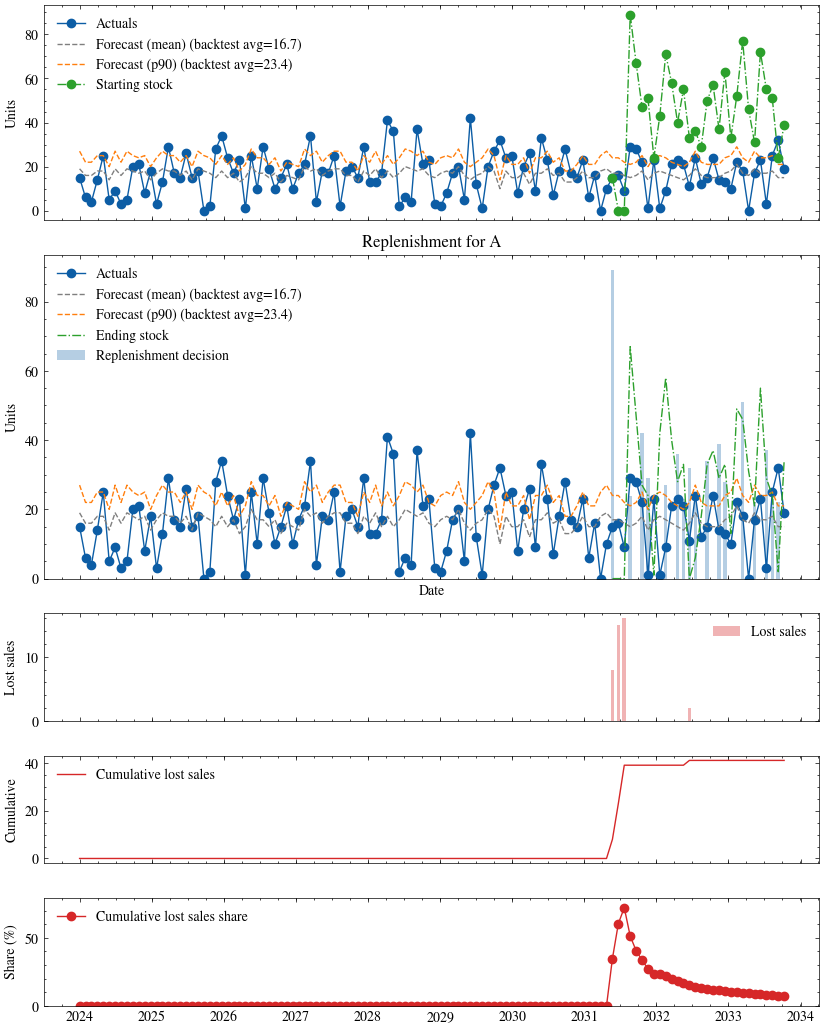

In [12]:
plot_replenishment_decisions(df, rop_percentile_decision_df, unique_id=example_id)


## ROP policy with aggregation window optimization
Uses time-aggregated optimization to select both window and percentile.


[9 8 7]


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

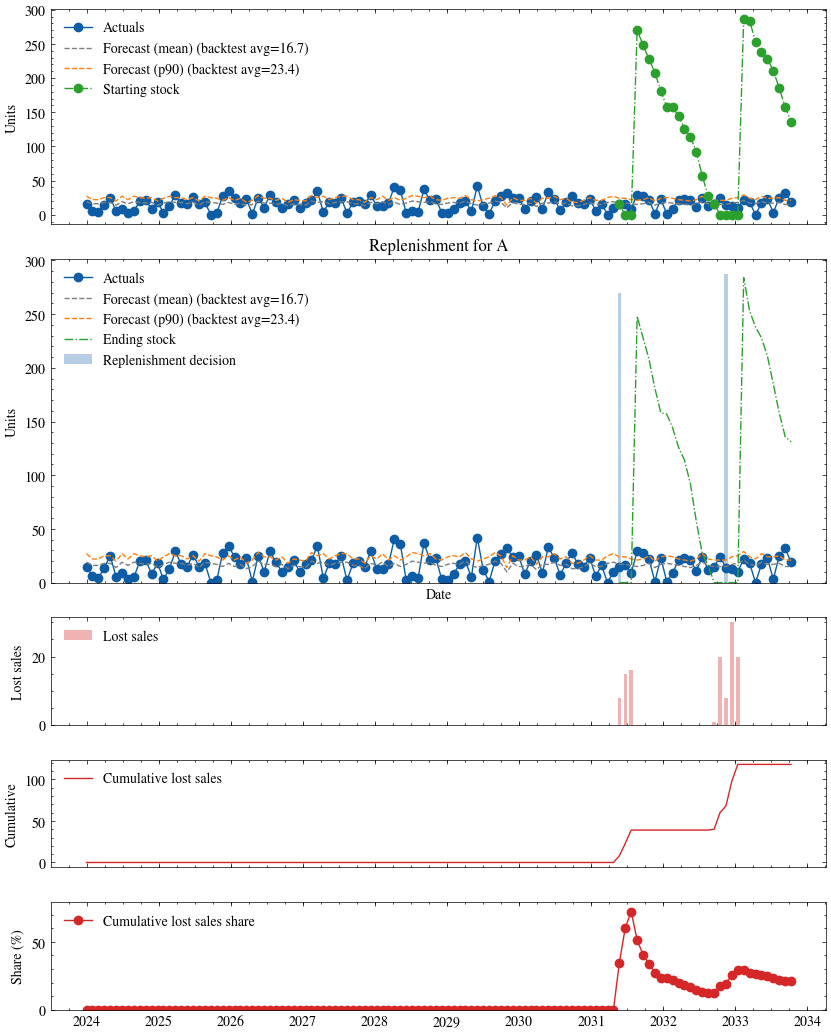

In [20]:
rop_agg_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
    policy_mode="rop",
)
rop_agg_windows = {
    unique_id: result.window
    for unique_id, result in rop_agg_results.items()
}

rop_agg_forecast_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=rop_agg_windows,
    forecast_horizon=rop_agg_windows,
)
rop_agg_simulations = {}
for unique_id, config in rop_agg_forecast_configs.items():
    choice = rop_agg_results[unique_id]
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
        aggregation_window=choice.window,
    )
    rop_agg_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

rop_agg_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_agg_simulations,
    aggregation_window={
        uid: rop_agg_results[uid].window
        for uid in rop_agg_simulations
    },
    percentile_target={
        uid: rop_agg_results[uid].target
        for uid in rop_agg_simulations
    },
    review_period=rop_agg_windows,
    forecast_horizon=rop_agg_windows,
    rmse_window=rop_agg_windows,
)
rop_agg_decision_df = replenishment_decision_rows_to_dataframe(
    rop_agg_decision_rows,
    library="pandas",
)
print(rop_agg_decision_df.aggregation_window.unique())

plot_replenishment_decisions(df, rop_agg_decision_df, unique_id=example_id)